In [ ]:
"""
LunarLander debug note
Initially, used the same code I used for cartpole.
Would not train, so printed out the probs. When the model is first made, it is fairly distributed like this [[0.2660, 0.2257, 0.2731, 0.2352]]. However, after training for 1000 steps,
it converges to a certain action like this - tensor([[9.9943e-01, 4.8898e-04, 7.9276e-05, 4.1656e-08]]
Applied entropy for more exploration. Didn't work
Found much larger absolute value of advantages, returns, compared to cartpole. Especially, when terminated, the return is -100 which is the dominant cause for the returns.
Normalizing advantage solved the problem above. Now it doesn't fixate in a certain action.
Then, action_probability turned into a somewhat uniform distribution. Therefore, printed out the losses.
Actor loss:  tensor(-1.9073e-08, device='cuda:0', grad_fn=<NegBackward0>) Critic loss:  tensor(15.9172, device='cuda:0', grad_fn=<MseLossBackward0>)
Entropy:  tensor(1.3784, device='cuda:0', grad_fn=<MeanBackward0>)
Found out that Actor loss is extremely small. Therefore, actor layer was barely getting updated.
Reason: log prob is pretty much uniform when model is initialized and the advantage is normalized with mean 0. We calculate actor_loss = (advantages * log_probs).mean()
This converges to the mean of the normal distribution (since log_probs is uniform), and therefore to 0.
Try with normalizing the n-step rewards instead of the advantage.
Reference https://github.com/nikhilbarhate99/Actor-Critic-PyTorch/blob/master/train.py
The only difference between my model and the reference model was the reduction method of actor and critic loss. Reference model used sum, my model used mean.
mean vs. sum was not the problem. The dimensions of log_probs, returns, state_values were all different in my code and was broadcasting very wierdly. That's why step-wise calculation of the reference code
worked, but my code didn't. Should pay more attention to dimensions, and also debugging warnings because I was ignoring the dimension disparity.
Trains well using mean. Maybe even better.
Solved all the bugs and trained both sync and async models. Both took too much time and didn't train well.
Compared to the reference code which ran in a single environment, I had my code running in 8 environments, and therefore decreased the learning rate from 0.02 -> 0.005.
Results: lr = 3e-3 (linear decay), 8 envs, 500 epsiodes -> MC: 107.6 average  8-step: 114.6 average
lr = 3e-3 (linear decay), 8 envs, 1000 episodes -> MC: -11.4 average  8-step: -35.6 average
"""


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [ ]:
!pip install gymnasium
!pip install pygame
!pip install wheel setuptools
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379371 sha256=b931b737a92f3fb54b0abee4e43a2b2ac4dadc5fba11033687dfbb02cb5b414b
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:
!pip uninstall -y box2d-py
!pip install box2d pygame swig
!pip install "gymnasium[box2d]" --no-deps

Found existing installation: box2d-py 2.3.5
Uninstalling box2d-py-2.3.5:
  Successfully uninstalled box2d-py-2.3.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 20.7 MB/s eta 0:00:00


In [ ]:
# New implementation referring to https://github.com/nikhilbarhate99/Actor-Critic-PyTorch/blob/master/train.py

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

class ActorCritic(nn.Module):

    # Increased hidden dim to (128, 128) compared to cartpole as the input_dim is more complex
    def __init__(self, input_dim, output_dim, hidden_dims=(128, 128)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            # nn.Linear(hidden_dims[0], hidden_dims[1]),
            # nn.ReLU()
        )
        self.actor_layer = nn.Linear(hidden_dims[0], output_dim)
        self.critic_layer = nn.Linear(hidden_dims[0], 1)

        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, x):
        x = self.net(x)
        action_probs = F.softmax(self.actor_layer(x), dim=-1)
        state_value = self.critic_layer(x)

        action_distribution = Categorical(action_probs)
        action = action_distribution.sample()

        self.logprobs.append(action_distribution.log_prob(action))
        self.state_values.append(state_value.squeeze())

        return action.item()

    def compute_return(self, gamma):
        returns = []
        R = 0
        for r in reversed(self.rewards):
            R = r + gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        return returns

    def calculate_loss(self, gamma):
        rewards = self.compute_return(gamma).detach()

        # CRITICAL BUG - log_probs' shape was [90, 1], state_values' [90, 1, 1], rewards' [90] -- should read the warning messages more carefully from now on.
        # print("log_probs.shape", self.logprobs.shape)
        # print("state_values.shape", self.state_values.shape)
        # print("returns.shape", returns.shape)

        loss = 0
        for logprob, value, reward in zip(self.logprobs, self.state_values, rewards):
            value = value.to('cpu')
            advantage = reward - value.detach()
            action_loss = -logprob * advantage
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)
        return loss

    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]



In [ ]:
from tqdm import tqdm

class A2CAgent:
    def __init__(self, env, num_episodes=1000, max_steps=500, gamma=0.99, lr=1e-3, num_steps = 5):
        random_seed = 543
        torch.manual_seed(random_seed)
        self.env = env
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.gamma = gamma
        self.lr = lr
        self.num_steps = num_steps
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = ActorCritic(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

    def train(self):
        episode_rewards = []
        episode_steps = []

        for episode in tqdm(range(self.num_episodes)):
            state, _ = self.env.reset()
            episode_reward = 0
            steps = 0
            done = False

            while not done and steps < self.max_steps:
                steps += 1
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
                action = self.policy_net(state_tensor)

                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.policy_net.rewards.append(reward)
                episode_reward += reward
                state = next_state

                # every n steps, calculate losses, update the actor & critic, then refresh the saved lists
                # if (steps % self.num_steps == 0) or done:
                if done:
                    self.optimizer.zero_grad()
                    loss = self.policy_net.calculate_loss(self.gamma)
                    loss.backward()
                    self.optimizer.step()
                    self.policy_net.clearMemory()

            if episode % 100 == 0:
                print(episode, "reward: ", episode_reward, "steps: ", steps)

            episode_rewards.append(episode_reward)
            episode_steps.append(steps)

        self.env.close()
        return np.array(episode_rewards), np.array(episode_steps)


In [ ]:
import gymnasium as gym

env = gym.make('LunarLander-v3')
env.reset(seed=543)
num_episodes = 500
max_steps = 1000
lr = 0.02


a2c_model_ll =  A2CAgent(env, num_episodes=num_episodes, max_steps=max_steps, lr=lr, num_steps = 8)

state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(a2c_model_ll.device)
rewards, steps = a2c_model_ll.train()


  0%|          | 1/500 [00:00<04:23,  1.89it/s]

0 reward:  -305.98365456353747 steps:  90


 20%|██        | 102/500 [00:27<02:04,  3.20it/s]

100 reward:  -398.5175385073768 steps:  195


 40%|████      | 201/500 [01:03<03:49,  1.30it/s]

200 reward:  -352.8601655087948 steps:  596


 60%|██████    | 301/500 [01:53<01:41,  1.96it/s]

300 reward:  -25.805601968050766 steps:  204


 80%|████████  | 401/500 [03:34<02:33,  1.55s/it]

400 reward:  22.05918520269557 steps:  1000


100%|██████████| 500/500 [05:19<00:00,  1.57it/s]


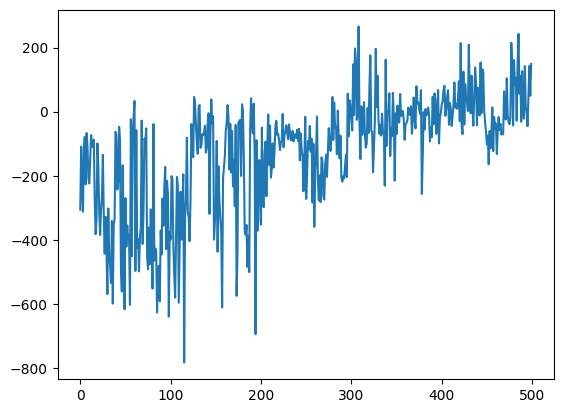

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(rewards)), rewards)
plt.show()

In [ ]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(99)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ActorCritic(nn.Module):

    # reference model used only 1 layer. Will experiment both
    def __init__(self, input_dim, output_dim, hidden_dims=(128, 128)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            # nn.Linear(hidden_dims[0], hidden_dims[1]),
            # nn.ReLU()
        )
        self.actor_layer = nn.Linear(hidden_dims[1], output_dim)
        self.critic_layer = nn.Linear(hidden_dims[1], 1)

    def forward(self, x):
        x = self.net(x)
        action_probs = F.softmax(self.actor_layer(x), dim=-1)
        value = self.critic_layer(x)
        return action_probs, value


In [1]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR


class A2CAgent:
    def __init__(self, env_id, num_episodes=1000, max_steps=500, gamma=0.99, lambda_GAE=1, lr=1e-3, num_steps=0, num_envs=8, vectorization_mode = "sync"):
        # using vectorized environments to boost training speed
        self.env = gym.make_vec(env_id, num_envs=num_envs, vectorization_mode=vectorization_mode)
        self.seed = 123
        self.num_envs = num_envs
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.gamma = gamma
        self.lambda_GAE = lambda_GAE
        self.lr = lr
        self.num_steps = num_steps
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = ActorCritic(self.env.single_observation_space.shape[0], self.env.single_action_space.n).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        # added scheduler after observing divergence after getting close to solving
        self.scheduler = StepLR(self.optimizer, step_size=100, gamma=0.9)
        self.loss = nn.MSELoss()

    # choosing action from policy's probability distribution
    def choose_action(self, state):
        probs, _ = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action

    # computing the GAE
    def compute_returns(self, rewards, values, next_value):
        T, N = rewards.shape
        advantages = torch.zeros_like(rewards)
        gae = torch.zeros(N, device=rewards.device)
        for t in reversed(range(T)):
            # temporal difference error
            td = rewards[t] + self.gamma * values[t + 1] - values[t]
            # higher labmda -> more sampling, lower lambda -> more bootstrapping
            gae = td + self.gamma * self.lambda_GAE * gae
            advantages[t] = gae

        # compute returns by adding value to advantage
        returns = advantages + values[:-1]

        # normalize advantage across timesteps and environments
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        return returns, advantages

    # computing the gamma decaying rewards
    # def compute_returns(self, rewards):
    #     """
    #     Args:
    #         rewards: torch.Tensor of shape [T, N] where
    #                 T = rollout steps, N = num_envs
    #     Returns:
    #         returns: torch.Tensor of shape [T, N], normalized
    #     """
    #     rewards = torch.stack(rewards)

    #     T, N = rewards.shape
    #     returns = torch.zeros_like(rewards)
    #     R = torch.zeros(N, device=rewards.device)
    #     for t in reversed(range(T)):
    #         R = rewards[t] + self.gamma * R
    #         returns[t] = R

    #     # Normalize returns across all timesteps and environments
    #     returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    #     return returns


    def train(self):
        episode_rewards = []
        episode_steps = []

        for episode in tqdm(range(self.num_episodes)):
            state, _ = self.env.reset(seed=self.seed)
            done = np.zeros(self.num_envs, dtype=bool)
            episode_reward = np.zeros(self.num_envs)
            values, rewards, log_probs = [], [], []
            done_mask = np.zeros(self.num_envs, dtype=bool)
            done_steps = np.zeros(self.num_envs)
            steps = 0

            while not np.all(done_mask) and steps < self.max_steps:
                steps += 1
                state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device)
                action_probs, value = self.policy_net(state_tensor)
                action_dist = torch.distributions.Categorical(action_probs)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)

                next_state, reward, terminated, truncated, _ = self.env.step(action.cpu().numpy())
                done = np.logical_or(terminated, truncated)
                done_steps = np.where(np.logical_and(done, ~done_mask), steps, done_steps)
                done_mask = np.logical_or(done_mask, done)
                # record when each environment is done
                reward = np.where(done_mask, 0.0, reward)

                # saves the values, rewards, log_probs which are used to calculate the n_step returns, actor loss, and critic loss
                values.append(value.squeeze())
                rewards.append(torch.tensor(reward, dtype=torch.float32).to(self.device))  # shape: (num_envs,)
                log_probs.append(log_prob)

                episode_reward += reward
                state = next_state


                # finish full trajectory, then update
                if self.num_steps == 0:
                    if np.any(done):
                        with torch.no_grad():
                            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(self.device)
                            _, next_value = self.policy_net(next_state_tensor)
                            done_tensor = torch.tensor(done, dtype=torch.float32).to(self.device)
                            next_value = next_value.squeeze() * (1 - done_tensor)

                        values = torch.stack(values)  # shape: (n_steps, num_envs)
                        returns, advantages = self.compute_returns(rewards, values, next_value)  # shape: (n_steps, num_envs)
                        returns, advantages = returns.transpose(0, 1), advantages.transpose(0, 1)  # shape: (num_envs, n_steps)
                        log_probs = torch.stack(log_probs).transpose(0, 1)  # shape: (num_envs, n_steps)
                        values = values.transpose(0, 1)  # shape: (num_envs, n_steps)

                        actor_loss = - (log_probs * advantages.detach()).mean()
                        critic_loss = self.loss(returns, values)

                        loss = actor_loss + critic_loss
                        self.optimizer.zero_grad()
                        loss.backward()
                        self.optimizer.step()
                        self.scheduler.step()

                        values = []
                        rewards = []
                        log_probs = []
                # every n steps for each environment, calculate losses, update the actor & critic, then refresh the saved lists
                else:
                    if (steps % self.num_steps == 0) or np.any(done):
                        with torch.no_grad():
                            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(self.device)
                            _, next_value = self.policy_net(next_state_tensor)
                            done_tensor = torch.tensor(done, dtype=torch.float32).to(self.device)
                            next_value = next_value.squeeze() * (1 - done_tensor)

                        values = torch.stack(values)  # shape: (n_steps, num_envs)
                        returns, advantages = self.compute_returns(rewards, values, next_value)  # shape: (n_steps, num_envs)
                        returns, advantages = returns.transpose(0, 1), advantages.transpose(0, 1)  # shape: (num_envs, n_steps)
                        log_probs = torch.stack(log_probs).transpose(0, 1)  # shape: (num_envs, n_steps)
                        values = values.transpose(0, 1)  # shape: (num_envs, n_steps)

                        actor_loss = - (log_probs * advantages.detach()).mean()
                        critic_loss = self.loss(returns, values)

                        loss = actor_loss + critic_loss
                        self.optimizer.zero_grad()
                        loss.backward()
                        self.optimizer.step()
                        self.scheduler.step()

                        values = []
                        rewards = []
                        log_probs = []


            episode_rewards.append(episode_reward)
            episode_steps.append(steps)

            if episode % 20 == 0:
               print('Episode {}\tlengths: {}\treward: {}]\tfull length: {}'.format(episode, done_steps, episode_reward, steps))

            if episode % 10 == 0:
                print(f"\n[Episode {episode}]")
                print(f"Reward (mean): {np.mean(episode_reward):.2f}")
                print(f"Actor Loss: {actor_loss.item():.4f} | Critic Loss: {critic_loss.item():.4f}")

            episode_rewards.append(episode_reward)
            episode_steps.append(steps)

        self.env.close()
        return np.array(episode_rewards), np.array(episode_steps)


In [ ]:
import gymnasium as gym

env_id = 'LunarLander-v3'
num_episodes = 250
max_steps = 500
lr = 3e-3


a2c_model_ll =  A2CAgent(env_id, num_episodes=num_episodes, max_steps=max_steps, lr=lr, num_envs=8)

rewards, steps = a2c_model_ll.train()



  0%|          | 1/250 [00:00<01:16,  3.24it/s]

Episode 0	lengths: [ 66.  75.  98.  94.  92. 107.  93.  70.]	reward: [  13.6915997  -263.37211526 -489.37471368 -409.57435665 -154.14043781
 -254.78781574 -291.17212385   -6.37326846]]	full length: 107

[Episode 0]
Reward (mean): -231.89
Actor Loss: 0.0787 | Critic Loss: 122.5400


  3%|▎         | 8/250 [00:02<01:24,  2.88it/s]


KeyboardInterrupt: 

In [ ]:
import gymnasium as gym

env_id = 'LunarLander-v3'
num_episodes = 250
max_steps = 500
lr = 3e-3


a2c_model_ll_n_step =  A2CAgent(env_id, num_episodes=num_episodes, max_steps=max_steps, lr=lr, num_envs=8, num_steps=8)

rewards, steps = a2c_model_ll_n_step.train()



  0%|          | 1/250 [00:00<01:30,  2.76it/s]

Episode 0	lengths: [106. 117. 112.  79.  96.  67. 113.  82.]	reward: [ -22.55050259 -169.41915375 -353.54822737    0.76927503 -228.97853925
   44.214354   -265.86482571  -17.67306843]]	full length: 117


  8%|▊         | 21/250 [00:20<05:42,  1.49s/it]

Episode 20	lengths: [125.   0.   0. 116. 366. 137. 456. 279.]	reward: [116.36412758  80.08864903 -16.6846244  -84.3282395  -98.91494999
 106.15055624 -22.86922107  81.94137352]]	full length: 500


 16%|█▋        | 41/250 [00:50<05:04,  1.46s/it]

Episode 40	lengths: [248.   0. 440. 327.   0.   0.   0.   0.]	reward: [  86.28645126   -4.37009736 -115.50710313   86.79018109   72.17528142
  -24.37063182  -28.06925991   -6.04772402]]	full length: 500


 24%|██▍       | 61/250 [01:20<04:48,  1.53s/it]

Episode 60	lengths: [  0. 296. 393. 371.   0.   0.   0. 380.]	reward: [ -45.7843188     4.39738952 -112.64037826   13.47258454   10.60136399
  115.40270986    1.64946024 -125.25461649]]	full length: 500


 32%|███▏      | 81/250 [01:50<04:05,  1.45s/it]

Episode 80	lengths: [0. 0. 0. 0. 0. 0. 0. 0.]	reward: [-88.21609004 -69.33490541 -88.69812217   6.02891035  51.60202821
 -41.77931168  -7.73540716 -46.55046825]]	full length: 500


 40%|████      | 101/250 [02:21<03:47,  1.53s/it]

Episode 100	lengths: [  0.   0.   0.   0. 225.   0. 388.   0.]	reward: [-30.95646777 -29.87676736  51.40022567 -16.28650488  31.6514792
 -14.54568409  79.72961868 -25.91622604]]	full length: 500


 48%|████▊     | 121/250 [02:50<03:06,  1.44s/it]

Episode 120	lengths: [  0.   0.   0.   0.   0. 408.   0.   0.]	reward: [-42.59438202  25.14250503  12.70797343 -17.83840731 -16.74930779
  96.89810108 -36.54405735  25.75221892]]	full length: 500


 56%|█████▋    | 141/250 [03:21<02:46,  1.52s/it]

Episode 140	lengths: [  0.   0. 482.   0.   0.   0.   0.   0.]	reward: [ -8.53117705 -58.76129762   6.1454562   -3.41386634  -7.33455266
 -57.34202336 -54.68373269  -6.25903347]]	full length: 500


 64%|██████▍   | 161/250 [03:50<02:09,  1.45s/it]

Episode 160	lengths: [  0.   0.   0.   0. 301.   0.   0.   0.]	reward: [-10.52178745 -81.97128026 -12.69847061 -30.66711715 -93.49149373
 -15.91025477 -39.02760448  -3.72865337]]	full length: 500


 72%|███████▏  | 181/250 [04:21<01:46,  1.55s/it]

Episode 180	lengths: [0. 0. 0. 0. 0. 0. 0. 0.]	reward: [ 81.58695124  -7.91522571  60.51844845  -1.55741818  -9.79718818
   1.92758753 -56.76439424  27.17029499]]	full length: 500


 80%|████████  | 201/250 [04:50<01:10,  1.45s/it]

Episode 200	lengths: [  0. 346.   0.   0.   0.   0.   0.   0.]	reward: [-53.98270802  -8.13978823 -29.58791056  61.37910717 -21.73085266
 114.83108107 -57.48877056   4.10646977]]	full length: 500


 88%|████████▊ | 221/250 [05:21<00:45,  1.55s/it]

Episode 220	lengths: [0. 0. 0. 0. 0. 0. 0. 0.]	reward: [113.22084507 119.46835981 -19.42671678 -67.19585071 -53.92528615
 -36.46967794 -29.71173904 -71.55999521]]	full length: 500


 96%|█████████▋| 241/250 [05:50<00:13,  1.46s/it]

Episode 240	lengths: [  0.   0.   0. 349.   0.   0.   0. 449.]	reward: [-12.30689445   6.56071939 109.38922876  95.14043036 121.27252072
 133.04568868 -30.15101218 -74.08017161]]	full length: 500


100%|██████████| 250/250 [06:04<00:00,  1.46s/it]


In [ ]:
import gymnasium as gym

env_id = 'LunarLander-v3'
num_episodes = 250
max_steps = 500
lr = 3e-3


a2c_model_ll_GAE =  A2CAgent(env_id, num_episodes=num_episodes, max_steps=max_steps, lr=lr, num_envs=8, num_steps=8, lambda_GAE = 1)

rewards, steps = a2c_model_ll_GAE.train()


  0%|          | 1/250 [00:00<01:26,  2.87it/s]

Episode 0	lengths: [ 96. 107.  99.  78. 114.  64. 112.  74.]	reward: [-215.5885679   -84.9838497  -190.79254466  -66.27817651  -10.97595193
  -10.60589694   -4.46228457  -19.36524186]]	full length: 114


  2%|▏         | 6/250 [00:02<01:50,  2.22it/s]


KeyboardInterrupt: 

In [ ]:
# env_id = 'LunarLander-v3'
# num_episodes = 250
# max_steps = 500
# lr = 3e-3

# a2c_model_ll_async =  A2CAgent(env_id, num_episodes=num_episodes, max_steps=max_steps, lr=lr, num_steps = 8, vectorization_mode="async")

# rewards_async, steps_async = a2c_model_ll_async.train()

In [ ]:
import gymnasium as gym
import torch
import numpy as np
from gymnasium.wrappers import RecordVideo
import os

# Create folder to save the video
video_folder = "./video"
os.makedirs(video_folder, exist_ok=True)

# Wrap the environment with RecordVideo
env = gym.make('LunarLander-v3', render_mode='rgb_array')
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

num_episodes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

episode_rewards = []

for i in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    episode_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            action_probs, _ = a2c_model_ll.policy_net(state)
            # action_dist = torch.distributions.Categorical(action_probs)
            # action = action_dist.sample().item()
            action = torch.argmax(action_probs, dim=1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

    episode_rewards.append(episode_reward)
    print(f"Episode {i+1} Reward: {episode_reward}")

env.close()

episode_rewards = np.array(episode_rewards)
print(f"Average Reward over {num_episodes} episodes: {np.mean(episode_rewards)}")


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 1 Reward: -36.62342980788866
Episode 2 Reward: -38.373842536437955
Episode 3 Reward: -58.545805604877685
Episode 4 Reward: -75.83506775742012
Episode 5 Reward: -23.36014906321702
Episode 6 Reward: -24.5306988390538
Episode 7 Reward: -22.57933121865689
Episode 8 Reward: -63.79716400080697
Episode 9 Reward: -33.83218625711889
Episode 10 Reward: -30.1908202896843
Average Reward over 10 episodes: -40.76684953751624


In [ ]:
import gymnasium as gym
import torch
import numpy as np
from gymnasium.wrappers import RecordVideo
import os

# Create folder to save the video
video_folder = "./video"
os.makedirs(video_folder, exist_ok=True)

# Wrap the environment with RecordVideo
env = gym.make('LunarLander-v3', render_mode='rgb_array')
env = RecordVideo(env, video_folder=video_folder, name_prefix="n_step", episode_trigger=lambda e: True)

num_episodes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

episode_rewards = []

for i in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    episode_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            action_probs, _ = a2c_model_ll_n_step.policy_net(state)
            # action_dist = torch.distributions.Categorical(action_probs)
            # action = action_dist.sample().item()
            action = torch.argmax(action_probs, dim=1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

    episode_rewards.append(episode_reward)
    print(f"Episode {i+1} Reward: {episode_reward}")

env.close()

episode_rewards = np.array(episode_rewards)
print(f"Average Reward over {num_episodes} episodes: {np.mean(episode_rewards)}")


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 1 Reward: -13.17687467242267
Episode 2 Reward: -15.469289465006568
Episode 3 Reward: 272.16523271266203
Episode 4 Reward: 285.55538538483313
Episode 5 Reward: -180.61322137554254
Episode 6 Reward: 243.65798138698761
Episode 7 Reward: 20.458904703214543
Episode 8 Reward: -2.172358309046487
Episode 9 Reward: 267.2319089443415
Episode 10 Reward: -209.05458302223207
Average Reward over 10 episodes: 66.85830862877886
